In [2]:
import numpy as np
from matplotlib import pyplot as plt

## Реализация метода линейной регрессии

Требования:

* l1-регуляризация
* l2-регуляризация
* При обучении данные подаются в SGD с помощью итератора
* Для нахождения весов используется стохастический градиентный спуск
* Каждый шаг градиентного спуска использует ровно один обучающий пример
* Стохастический градиентный спуск использует приближенно вычисленный градиент

### Необходимо реализовать следующие (-ие) класс (-ы)

In [3]:
class Regression(object):
    '''Класс для предсказания действительно-значного выхода по входу - вектору из R^n. 
    Используется линейная регрессия, то есть если вход X \in R^n, вектор весов W \in R^{n+1},
    то значение регрессии - это [X' 1] * W, то есть y = x1*w1 + x2*w2 + xn*wn + wn+1.
    Обучение - подгонка весов W - будет вестись на парах (x, y).
    
    Параметры
    ----------
    sgd : объект класса SGD
    trainiterator: объект класса TrainIterator
    n_epoch : количество эпох обучения (default = 1)
    '''
    def __init__(self, sgd, trainiterator, n_epoch=1):
        self.sgd = sgd
        self.trainiterator = trainiterator
        self.n_epoch = n_epoch
     
    def fit(self, X, y):
        '''Обучение модели.
        
        Парметры
        ----------
        X : двумерный массив признаков размера n_samples x n_features
        y : массив/список правильных значений размера n_samples
        
        Выход
        -------
        Метод обучает веса W
        '''
        self.W = np.zeros(X.shape[1])
        for a, b in self.trainiterator:
            self.W = self.sgd.step(a, b, self.W)
        
    def predict(self, X):
        """ Предсказание выходного значения для входных векторов
        
        Параметры
        ----------
        X : двумерный массив признаков размера n_samples x n_features
        
        Выход
        -------
        y : Массив размера n_samples
        """
        return X @ self.W
        
    def score(self, y_gt, y_pred):
        """Возвращает точность регрессии в виде (1 - u/v), 
        где u - суммарный квадрат расхождения y_gt с y_pred,
        v - суммарный квадрат расхождения y_gt с матожиданием y_gt
        
        Параметры
        ----------
        y_gt : массив/список правильных значений размера n_samples
        y_pred : массив/список предсказанных значений размера n_samples
        
        Выход
        -------
        accuracy - точность регрессии
        """
        return 1 - sum((y_gt - y_pred) ** 2) / sum((y_gt - y_gt.mean()) ** 2)

In [4]:
class SGD(object):
    '''Класс для реализации метода стохастического градиентного спуска. 
    
    Параметры
    ----------
    grad : функция вычисления градиента
    alpha : градиентный шаг (default = 1.)
    
    '''
    def __init__(self, grad, alpha=1.):
        self.grad = grad
        self.alpha = alpha
     
    def step(self, X, y, W):
        '''Один шаг градиентного спуска.
        
        Параметры
        ----------
        X : двумерный массив признаков размера n_samples x n_features
        y : массив/список правильных значений размера n_samples
        W : массив весов размера n_weights
        
        Выход
        -------
        Метод возвращает обновленные веса
        '''
        return W - self.alpha * self.grad.grad(X, y, W)

In [5]:
class Grad(object):
    '''Класс для вычисления градиента по весам от функции потерь. 
    
    Параметры
    ----------
    loss : функция потерь
    delta : параметр численного дифференцирования (default = 0.000001)    
    '''
    def __init__(self, loss, delta=0.000001):
        self.loss = loss
        self.delta = delta
     
    def grad(self, X, y, W):
        '''Вычисление градиента.
        
        Параметры
        ----------
        X : двумерный массив признаков размера n_samples x n_features
        y : массив/список правильных значений размера n_samples
        W : массив весов размера n_weights
        
        Выход
        -------
        Метод возвращает градиент по весам W в точках X от функции потерь
        '''
        loss = self.loss.val(X, y, W)
        gradient = list()
        for d in np.eye(len(X)) * self.delta:
            gradient.append((self.loss.val(X, y, W + d) - loss) / self.delta)
        return np.array(gradient)

In [6]:
class Loss(object):
    '''Класс для вычисления функции потерь. 
    
    Параметры
    ----------
    l1_coef : коэффициент l1 регуляризации (default = 0)
    l2_coef : коэффициент l2 регуляризации (default = 0)
    '''
    def __init__(self, l1_coef=0, l2_coef=0):
        self.l1 = l1_coef
        self.l2 = l2_coef
     
    def val(self, X, y, W):
        '''Вычисление функции потерь.
        
        Параметры
        ----------
        X : двумерный массив признаков размера n_samples x n_features
        y : массив/список правильных значений размера n_samples
        W : массив весов размера n_weights
        
        Выход
        -------
        Метод возвращает значение функции потерь в точках X
        '''
        return (W @ X - y) ** 2 + self.l1 * sum(abs(W)) + self.l2 * sum(W ** 2)

In [7]:
class TrainIterator(object):
    '''Класс итератора для работы с обучающими данными. 
    
    Параметры
    ----------
    X : двумерный массив признаков размера n_samples x n_features
    y : массив/список правильных значений размера n_samples
    n_epoch : количество эпох обучения (default = 1)
    '''    
    def __init__(self, X, y, n_epoch=1):
        self.X = X
        self.y = y
        self.n_epoch = n_epoch
        self.i = -1
        self.epoch = 0
    
    def __iter__(self):
        '''Нужно для использования итератора в цикле for
        Здесь ничего менять не надо
        '''
        return self

    def __next__(self):
        '''Выдача следующего примера.
        
        Выход
        -------
        Метод возвращает очередной пример как из X, так и из y
        '''
        self.i += 1
        if self.i >= self.X.shape[0]: # len(self.X)
            self.i = 0
            self.epoch += 1
        if self.epoch >= self.n_epoch:
            raise StopIteration
        return self.X[self.i], self.y[self.i]

### Пример использования

Your accuracy is 0.9999999998148212


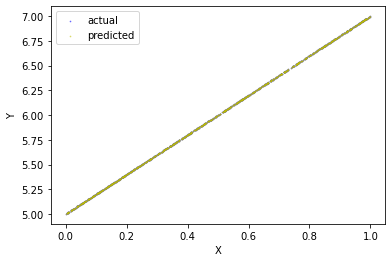

In [61]:
#TODO подгружаем данные в trainX, trainY, testX, testY
#TODO задаем alpha, delta, l1_coef, l2_coef, n_epoch

np.random.seed(2)
trainX = np.append(np.ones((1000, 1)), np.random.rand(1000, 1), axis=1)
trainY = np.array([5 * x0 + 2 * x1 for x0, x1 in trainX])

testX = np.append(np.ones((1000, 1)), np.random.rand(1000, 1), axis=1)
testY = np.array([5 * x0 + 2 * x1 for x0, x1 in testX])

trainiterator = TrainIterator(trainX, trainY, n_epoch=10)
loss = Loss(l1_coef=0, l2_coef=0)
grad = Grad(loss, delta=0.00001)
sgd = SGD(grad, alpha=0.5)
reg = Regression(sgd, trainiterator, n_epoch=1)
reg.fit(trainX, trainY)
y_pred = reg.predict(testX)
acc = reg.score(testY, y_pred)
print('Your accuracy is %s' % str(acc))

plt.scatter(x=testX[:, 1], y=testY, s=0.5, c='b', alpha=0.5, label='actual')
plt.scatter(x=testX[:, 1], y=y_pred, s=0.5, c='y', alpha=0.5, label='predicted')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Покройте ваш класс тестами

### Подберите оптимальные параметры для вашей модели

In [10]:
# Нужно подобрать alpha, delta, l1_coef, l2_coef, n_epoch для максимизации score